Przed oddaniem zadania upewnij się, że wszystko działa poprawnie.
**Uruchom ponownie kernel** (z paska menu: Kernel$\rightarrow$Restart) a następnie
**wykonaj wszystkie komórki** (z paska menu: Cell$\rightarrow$Run All).

Upewnij się, że wypełniłeś wszystkie pola `TU WPISZ KOD` lub `TU WPISZ ODPOWIEDŹ`, oraz
że podałeś swoje imię i nazwisko poniżej:

In [1]:
NAME = "Piotr Szuba"

---

# 1. Grafowe sieci neuronowe

W niniejszym zeszycie opiszemy i przeprowadzimy ewaluację 3 najpopularniejszych architektur grafowych sieci neuronowych, mianowicie:
- Graph Convolutional Network (**GCN**)
- Graph Sample and Aggregate (**GraphSAGE**)
- Graph Attention Network (**GAT**)

Wykorzystamy poznany w ramach poprzedniego laboratorium zbiór Cora i sprawdzimy jakość działania powyższych modeli w zadaniu klasyfikacji węzłów. Implementacje modeli są dostępne w bibliotece PyTorch-Geometric, natomiast do uczenia modeli wykorzystamy bibliotekę PyTorch-Lightning.

## 1.1. Załadowanie zbioru
Zbiory danych w PyTorch-Lightningu są przekazywane jako instancje obiektów `DataLoader` do metody `fit()` klasy `Trainer`. Można jednak użyć klasy `LightningDataModule` i w niej zdefiniować wszystkie data loadery wraz z wczytaniem właściwego zbioru. Zauważmy, że dotychczas rozważany zbiór danych Cora nie jest podzielony na mniejsze części (tj. mamy dokładnie jeden obiekt `Data`, który opisuje cały graf). Można wykorzystywać metody próbkowania grafów (np. `NeighborSampler`) i przez to uzyskać podział na mini-paczki, jednak zbiór Cora jest na tyle mały, że nie opłaca się go bardziej dzielić. Wykorzystamy natomiast fakt, że wczytywany obiekt `Planetoid` jest iterowalny i zwiera dokładnie jeden element. Możemy go zatem opakować w obiekt `DataListLoader` (dedykowana wersja `DataLoader`a zaimplementowana w PyTorch-Geometricu).

In [2]:
from IPython.display import Code, display

display(Code("src/dataset.py"))

import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataListLoader
from torch_geometric.datasets import Planetoid


class GraphData(pl.LightningDataModule):

    def __init__(self, dataset_name: str):
        super().__init__()

        self._dataset = self._load(dataset_name)

    def train_dataloader(self) -> DataLoader:
        return self._dataloader()

    def val_dataloader(self) -> DataLoader:
        return self._dataloader()

    def test_dataloader(self) -> DataLoader:
        return self._dataloader()

    def predict_dataloader(self) -> DataLoader:
        return self._dataloader()

    @property
    def num_node_features(self) -> int:
        return self._dataset.num_node_features

    @property
    def num_classes(self) -> int:
        return self._dataset.num_classes

    @property
    def data(self) -> Data:
        return self._dataset[0]

    @staticmethod
    def _load(dataset_name: str) -> Dataset:
        if dataset_name == "Cora":
            dataset = Planetoid(root="./data", name="Cora")
        else:
            raise ValueError(f"Unknown dataset: {dataset_name}")

        return dataset

    def _dataloader(self) -> DataLoader:
        # We can use the same DataLoader for all data splits, as there are
        # masks in the Data object that we will use for selecting the
        # appropriate nodes set. Moreover, we can set `shuffle=False` for all
        # splits, because we have only one `Data` object (there is nothing
        # to shuffle). Notice that we use PyTorch-Geometric's custom data loader
        # object, because the default PyTorch one does not know how to collate
        # `Data` objects in a batch.
        return DataListLoader(
            dataset=self._dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0,
        )

In [3]:
from src.dataset import GraphData


datamodule = GraphData(dataset_name="Cora")

c:\Python311\Lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  warnings.warn(
c:\Python311\Lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  warnings.warn(


## 1.2. Trenowanie modeli
Wszystkie wymienione modele grafowych sieci neuronowych zostały zaproponowane jako warstwy (z perspektywy głębokiego uczenia maszynowego), które możemy połączyć z dowolnymi innymi warstwami, aby utworzyć model (tzn. możemy wykorzystać znane aktywacje, warstwy liniowe itd.). Istotne dla nas jest jednak to, że grafowe sieci neuronowe (ang. *Graph Neural Networks - GNN*) nie są związane z jakąkolwiek funkcją kosztu i możemy je uczyć zarówno w scenariuszu nadzorowanym jak i nienadzorowanym. Temat modeli nienadzorowanych jest bardziej złożony, zatem na razie go pominiemy i wrócimy do niego w następnym zeszycie.

Na chwilę obecną będziemy rozważać scenariusz nadzorowanej klasyfikacji wierzchołków. Przeanalizujmy implementację klasy `SupervisedNodeClassificationGNN`:

In [4]:
display(Code("src/supervised.py"))

from typing import List, Optional, Tuple

import pytorch_lightning as pl
import torch
from sklearn.metrics import roc_auc_score
from torch import nn
from torch_geometric.data import Data


class SupervisedNodeClassificationGNN(pl.LightningModule):
    """Supervised node classification for a given GNN model."""

    def __init__(self, gnn: nn.Module, emb_dim: int, num_classes: int):
        super().__init__()

        self._gnn = gnn
        self._classification_head = nn.Sequential(
            nn.Linear(emb_dim, emb_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(emb_dim, num_classes),
            nn.LogSoftmax(dim=1),
        )

        self._loss_fn = nn.NLLLoss()

    def forward(
        self,
        x: torch.Tensor,
        edge_index: torch.Tensor,
    ) -> torch.Tensor:
        return self._gnn(x, edge_index)

    def training_step(self, batch: List[Data], batch_idx: int) -> torch.Tensor:
        data = batch[0]

        y_pred, y, auc = self._common_step(data=data, mask=data.train_mask)

        loss = self._loss_fn(input=y_pred, target=y)

        self.log("step", self.trainer.current_epoch)
        self.log("train/loss", loss.item(), on_epoch=True, on_step=False)
        self.log("train/auc", auc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch: List[Data], batch_idx: int):
        data = batch[0]

        _, _, auc = self._common_step(data=data, mask=data.val_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("val/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def test_step(self, batch: List[Data], batch_idx: int):
        data = batch[0]

        _, _, auc = self._common_step(data=data, mask=data.test_mask)

        self.log("step", self.trainer.current_epoch)
        self.log("test/auc", auc, on_epoch=True, on_step=False)

        return {"auc": auc}

    def predict_step(
        self,
        batch: List[Data],
        batch_idx: int,
        dataloader_idx: Optional[int] = None,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        data = batch[0]

        z = self(data.x, data.edge_index)
        y = data.y

        return z, y

    def _common_step(
        self,
        data: Data,
        mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, float]:
        z = self(data.x, data.edge_index)

        y_pred = self._classification_head(z)[mask]
        y = data.y[mask]

        if torch.is_tensor(y):
            if y.is_cuda:
                y = y.cpu()
                
        if torch.is_tensor(y_pred):
            if y_pred.is_cuda:
                y_pred = y_pred.cpu()   
                
        auc = roc_auc_score(
            y_true=y,
            y_score=y_pred.exp().detach(),
            multi_class="ovr",
        )

        return y_pred, y, auc
    
    def configure_optimizers(self):
        return torch.optim.AdamW(
            params=self.parameters(),
            lr=1e-3,
            weight_decay=5e-4,
        )

Jak już wspomnieliśmy modele grafowych sieci neuronowych mogą być stosowane w scenariuszu induktywnym. Pomimo, że przekazujemy pełną macierz atrybutów wierzchołków `data.x` oraz pełny zbiór krawędzi `data.edge_index`, funkcję kosztu oraz metrykę AUC obliczamy na wybranym pozbiorze wierzchołków. Podzbiór ten jest określany przez maskę zbioru treningowego `data.train_mask`, walidacyjnego `data.val_mask` oraz testowego `data.test_mask`. Na cele tego laboratorium możemy uznać taki scenariusz jako induktywny, jednak w rzeczywistych zastosowaniach musielibyśmy zadbać oto, aby na danym etapie uczenia (trening, walidacja, testowanie) pozostawiać tylko odpowiedni podzbiór krawędzi i wierzchołków (więcej o tym na kolejnym wykładzie!).


In [5]:
from src.supervised import SupervisedNodeClassificationGNN

Dla wszystkich modeli zdefiniujmy sobie zbiór wspólnych hiperparametrów:

In [6]:
hparams = {
    "num_epochs": 10,
    "hidden_dim":  256,
    "emb_dim": 128,
}

# 1.3. Graph Convolutional Network (GCN)
Grafowe sieci neuronowe po raz pierwszy w literaturze były proponowane już w okolicach 2008 roku, jednak dopiero rozwój i popularyzacja uczenia głębokiego pozwoliła na efektywne implementacje. Najpopularniejszym obecnie modelem grafowej sieci neuronowej jest **grafowa konwolucja** (GCN - *Graph Convolutional Network*), która została zaproponowana przez Kipfa w 2016 roku – [artykuł](https://arxiv.org/pdf/1609.02907.pdf). Praca ma już niespełna 23 tysiące cytowań i wiele obecnych GNNów jest oparta na niej.

Model GCN w każdej warstwie oblicza nowe cechy wierzchołków $H^{(l+1)}$ na podstawie obecnych cech $H^{(l)}$ w następujący sposób:

$$H^{(l+1)} = \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}H^{(l)}W^{(l)},$$
gdzie:
- $\hat{A} = A + I$ to macierz sąsiedztwa grafu z dołączonymi pętlami zwrotnymi na każdym wierzchołku (krawędź z danego wierzchołka do samego siebie)
- $\hat{D}$ to macierz stopnii węzłów (macierz diagonalna)
- $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}$ to tzw. symetryczna normalizacja macierzy sąsiedztwa
- $W^{(l)}$ to macierz wyuczalnych parametrów

Powyższa funkcja odgrywa rolę wcześniej wprowadzonej funkcji $\phi$. Poprzez dodanie pętli na każdym wierzchołku, uśredniane są cechy zarówno sąsiadów jak i cechy danego wierzchołka. Natomiast symetryczna normalizacja pozwala uwzględnić stopień danego wierzchołka oraz stopień sąsiada.

Często definicja powyższej reguły *propagacji* uwzględnia również funkcję aktywacji. W celu uniknięcia pomyłek, tutaj ją pomijamy – PyTorch-Geometric też nie stosuje funkcji aktywacji w implementacjach poszczególnych warstw.

Zobaczmy jak zaimplementować grafową sieć neuronową wykorzystującą konwolucję grafową. Utworzymy sieć dwuwarstwową (uwzględniającą zatem sąsiedztwo dwu-skokowe) – zobacz klasa `GCNModel`. Następnie wykorzystamy klasę `SupervisedNodeClassificationGNN` i bibliotekę `PyTorch-Lightning`, aby nauczyć model klasyfikacji wierzchołków na zbiorze Cora.

c:\Python311\Lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: p is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | GCNModel   | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

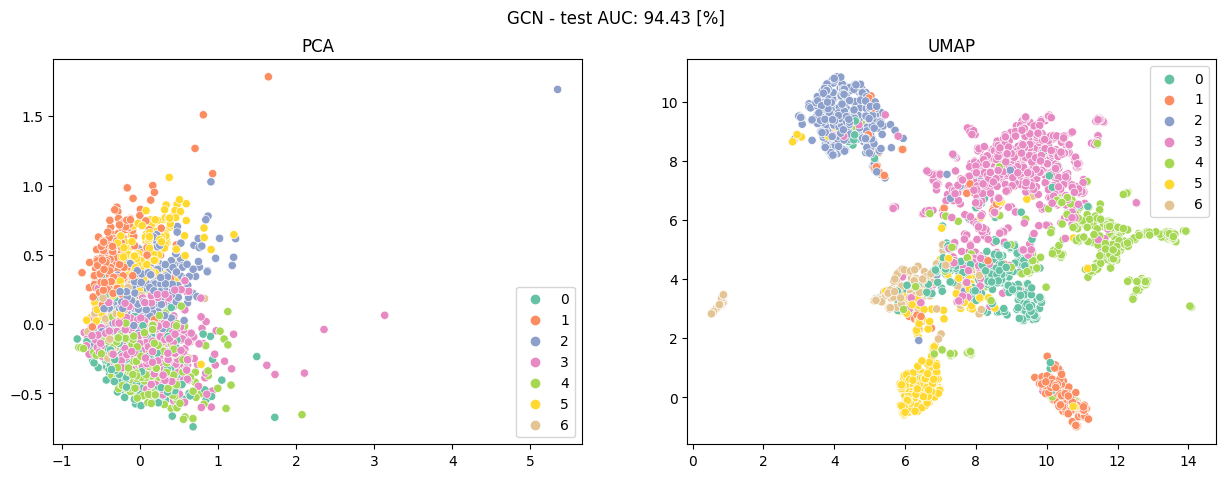

In [7]:
import matplotlib.pyplot as plt
from torch import nn
from torch_geometric.nn import GCNConv

from src.trainer import get_default_trainer
from src.utils import visualize_embeddings


class GCNModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = GCNConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z


    
def evaluate_gcn():
    gnn = GCNModel(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )

    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GCN",
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GCN - test AUC: {test_auc * 100.:.2f} [%]")
    
    plt.show()
    
evaluate_gcn()

## 1.4. Graph Sample and Aggregate (GraphSAGE)
W 2017 roku Hamilton opublikował [pracę](https://arxiv.org/pdf/1706.02216.pdf), w której rozważał induktywne uczenie grafowych sieci neuronowych oraz zaproponował sposób na osiągnięcie lepszej skalowalności metod GNNowych. Zaproponowana metoda (a właściwie rodzina metod) opiera się na idei próbkowania sąsiedztwa grafu (losowo wybrany podzbiór sąsiadów danego węzła) i następnie agregacji cech tak uzyskanej próbki sąsiadów. Zostały rozważone 3 metody agregacji: uśrednienie, LSTM oraz max pooling. Metoda była inspirowana bezpośrednio algorytmem Weisfeiler-Lehman test, a reguła propagacji jest zdefiniowana następująco (z perspektywy pojedynczego wierzchołka):

$$h^{(l)}_{\mathcal{N}(u)} = \text{AGGREGATE}^{(l)}(\{h^{(l)}_v, \forall v\in\mathcal{N}(u) \}) $$
$$h^{(l+1)}_u = W^{(l)} \cdot \text{CONCAT}(h^{(l)}_u, h^{(l)}_{\mathcal{N}(u)})$$

Widzimy zatem, że najpierw agregujemy cechy sąsiadów za pomocą wybranej metody agregacji, a następnie konkatenujemy wektor cech danego wierzchołka ze zagregowanym wektorem sąsiadów, po czym przemnażamy taki wektor przez macierz wag.

W PyTorch-Geometricu, metoda GraphSAGE (tutaj: `SAGEConv`) jest zaimplementowana delikatnie inaczej – reguła propagacji jest określona następująco (dla wariantu z uśrednieniem):

$$h^{(l+1)}_u = W^{(l)}_1 \cdot h^{(l)}_u + W^{(l)}_2 \cdot \text{mean}_{v\in\mathcal{N}(u)} h^{(l)}_v$$

Cechy danego wierzchołka i zagregowanego sąsiedztwa są przekształcane przez osobne wyuczalne macierze.

Analogicznie do modelu GCN przeprowadźmy ewaluację:

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type           | Params
--------------------------------------------------------
0 | _gnn                 | GraphSAGEModel | 799 K 
1 | _classification_head | Sequential     | 17.4 K
2 | _loss_fn             | NLLLoss        | 0     
--------------------------------------------------------
817 K     Trainable params
0         Non-trainable params
817 K     Total params
3.268     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

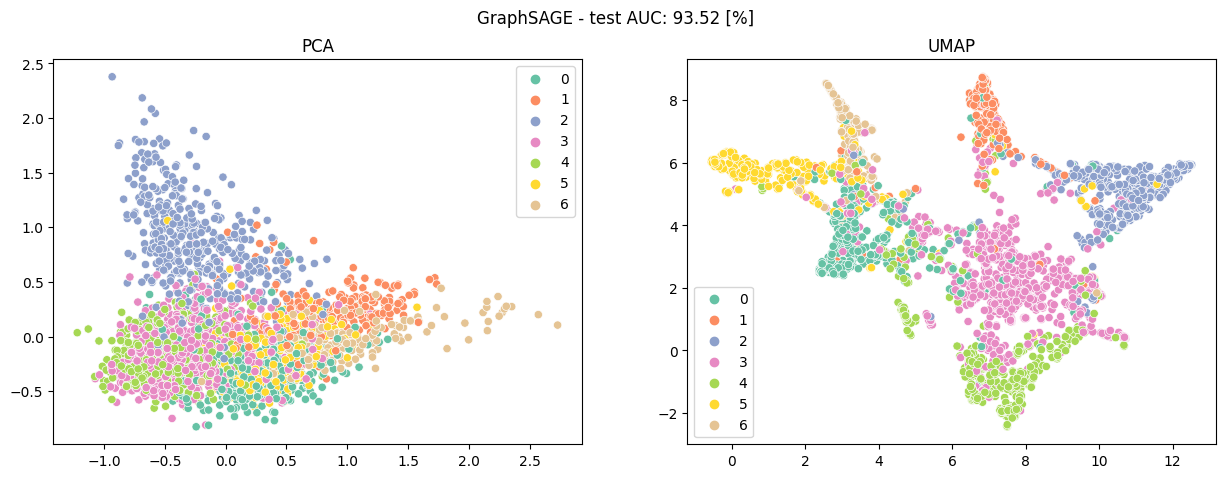

In [8]:
from torch_geometric.nn import SAGEConv


class GraphSAGEModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hidden_dim)
        self.act1 = nn.ReLU()
        self.conv2 = SAGEConv(hidden_dim, out_dim)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z
    
    
    
def evaluate_graphsage():
    gnn = GraphSAGEModel(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )
    
    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GraphSAGE",
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GraphSAGE - test AUC: {test_auc * 100.:.2f} [%]")
    
    plt.show()
    

evaluate_graphsage()

## 1.5. Graph Attention Network (GAT)
Również w 2017 roku, Velickovic opublikował [pracę](https://arxiv.org/pdf/1710.10903.pdf), która przetłumaczyła mechanizm uwagi znany z przetwarzania języka naturalnego do dziedziny grafów. Powstała metoda nazywana Graph Attention (GAT). Reguła propagacji jest określona następująco:

$$h^{(l+1)}_u = \alpha_{u,u} W^{(l)}h^{(l)}_u + \sum_{v \in \mathcal{N}(u)} \alpha_{u,v}W^{(l)}h^{(l)}_v $$

$$\alpha_{i, j} = \frac{\exp(\text{LeakyReLU}(a^T[W^{(l)}h^{(l)}_i || W^{(l)}h^{(l)}_j]))}{\sum_{k\in i\cup \mathcal{N}(i)} \exp(\text{LeakyReLU}(a^T[W^{(l)}h^{(l)}_i || W^{(l)}h^{(l)}_k]))},$$

gdzie:
- $W^{(l)}$ to wyuczalna macierz parametrów
- $a$ to wyuczalne parametry mechanizmu uwagi (ang. *attention parameters*)
- $\alpha$ to współczynniki mechanizmu uwagi (ang. *attention coefficients*)

Metoda pozwala również na wykorzystanie wielu głowic uwagi (ang. *multi-headed attention*).

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | GATModel   | 400 K 
1 | _classification_head | Sequential | 17.4 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
418 K     Trainable params
0         Non-trainable params
418 K     Total params
1.673     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

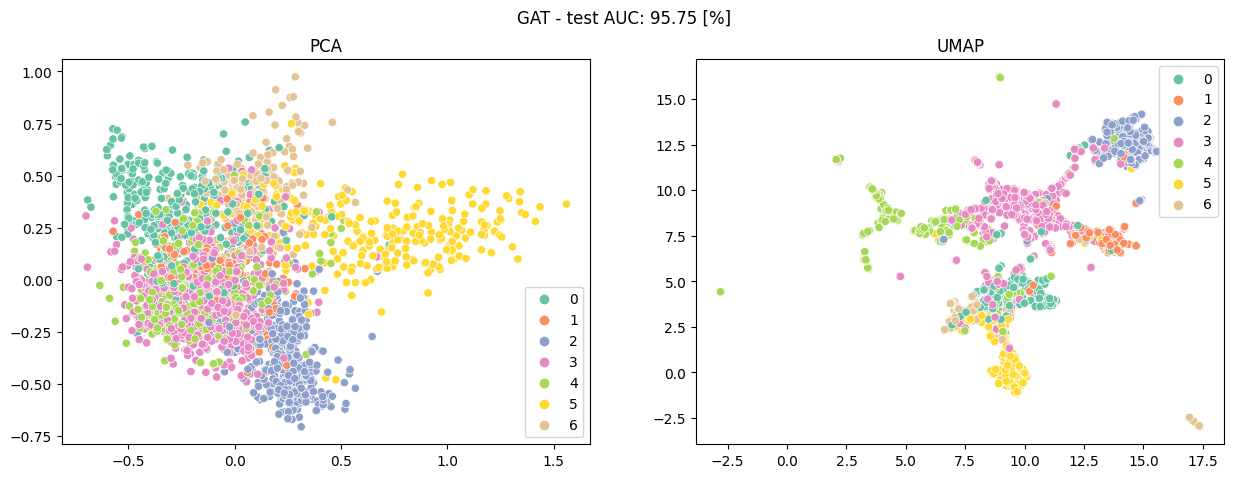

In [9]:
from torch_geometric.nn import GATConv


class GATModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=1)
        self.act1 = nn.ReLU()
        self.conv2 = GATConv(hidden_dim, out_dim, heads=1)
        self.act2 = nn.ReLU()

    def forward(self, x, edge_index):
        z = self.act1(self.conv1(x, edge_index))
        z = self.act2(self.conv2(z, edge_index))
        return z
    
    
    
def evaluate_gat():
    gnn = GATModel(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )
    
    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_GAT",
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"GAT - test AUC: {test_auc * 100.:.2f} [%]")
    
    plt.show()
    

evaluate_gat()

In [10]:
%load_ext tensorboard
%tensorboard --logdir ./data/logs --port 6006

# Zadania

## 1.1. Opis i ewaluacja wybranej warstwy GNN (3 pkt)
Korzystając z listy zaimplementowanych w PyTorch-Geometricu warstw grafowych sieci neuronowych, wybierz jedną z nich, a następnie:

a) Sprawdź jak w tej warstwie realizowana jest reguła propagacji – porównaj wzór z wyżej badanymi modelami oraz zastanów się jak rozumiesz zasadę działania. **Na zajęciach, powinieneś potrafić to wyjaśnić własnymi słowami.**

b) Analogicznie do modeli GCN, GraphSAGE oraz GAT, zaimplementuj model dwuwarstwowy i przeprowadź jego ewaluację w zadaniu nadzorowanej klasyfikacji wierzchołków.

GCN normalizuje cechy sąsiadów z użyciem stopni wierzchołków (D) i macierzy sąsiedztwa (A) przed ich agregacją i przekształceniem za pomocą warstwy liniowej (W^{(l)}) oraz funkcji aktywacji ReLU.

GraphSAGE wprowadza koncepcję "indywidualnych" funkcji agregujących dla każdego wierzchołka, które mogą być różne funkcje takie jak średnia, suma, maksimum, itp. Agregowane cechy są następnie przekształcane za pomocą warstwy liniowej i funkcji aktywacji.

GAT wprowadza mechanizm "uwagi", który pozwala modelowi na "ważenie" informacji od sąsiadów wierzchołka podczas agregacji. Każdy wierzchołek ma swoją własną wagę uwagi dla każdego sąsiada, co pozwala mu na skupienie się na bardziej "istotnych" sąsiadach.

GIN agreguje informacje od sąsiadów, przeskalowuje je, dodaje cechy aktualnego wierzchołka, a następnie przekształca je za pomocą sieci neuronowej (MLP).

$$h_v^{(l)} = MLP((1 + \epsilon) * h_v^{(l-1)} + \sum_{u \in N(v)} h_u^{(l-1)})$$

Graph Isomorphism Network

Potrafi rozróżniać grafy izomorficzne czyli majace te samą strukture ale inne etykiety.

Agreguje cechy ze wszystkich sąsiadujących wierzchołków. Często używany jest do tego prosty sumator

Następnie, do agregowanych cech sąsiadów dodaje się cechy samego wierzchołka, przeskalowane przez pewną wartość (1 + epsilon), gdzie epsilon jest parametrem uczonym przez sieć

Wynik powyższych operacji przekazywany jest przez sieć neuronową (często MLP, czyli wielowarstwowy perceptron), która przekształca go do nowych cech dla wierzchołka.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type             | Params
----------------------------------------------------------
0 | _gnn                 | SelectedGNNModel | 400 K 
1 | _classification_head | Sequential       | 17.4 K
2 | _loss_fn             | NLLLoss          | 0     
----------------------------------------------------------
417 K     Trainable params
0         Non-trainable params
417 K     Total params
1.670     Total estimated model params size (MB)


1433 256 128


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

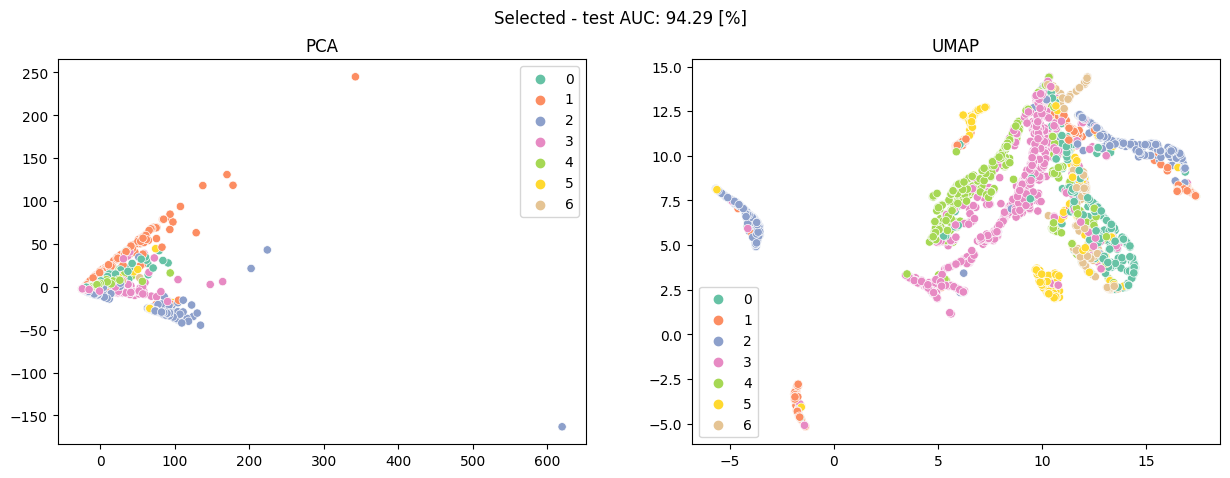

In [21]:
import torch
from torch_geometric.nn import GINConv
from torch.nn import Linear, ReLU

class SelectedGNNModel(nn.Module):
    def __init__(self, in_dim: int, hidden_dim: int, out_dim: int):
        super().__init__()
        self.act = ReLU()
        self.conv1 = GINConv(Linear(in_dim, hidden_dim))
        self.conv2 = GINConv(Linear(hidden_dim, out_dim))

    def forward(self, x, edge_index):
        z = self.act(self.conv1(x, edge_index))
        z = self.act(self.conv2(z, edge_index))
        return z
    
    
    
def evaluate_selected_gnn():
    gnn = SelectedGNNModel(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
    )
    
    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_Selected",
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    z, y = trainer.predict(model=model, datamodule=datamodule)[0]
    
    fig = visualize_embeddings(z=z, y=y)
    fig.suptitle(f"Selected - test AUC: {test_auc * 100.:.2f} [%]")
    
    plt.show()
    

evaluate_selected_gnn()
#evaluate_gcn()
#evaluate_graphsage()
#evaluate_gat()

## 1.2. Badanie głębokości grafowej sieci neuronowej (5 pkt)
a) Dla trzech powyżej przedstawionych modeli GNNowych oraz wybranej w zadaniu 1.1 warstwy, zaimplementuj klasę, która utworzy grafową sieci neuronową z dowolnie określoną liczbą warstw (w poprzednich przykładach używaliśmy 2-warstowego GNNa) zadanego typu.

b) Zbadaj jak głębokość grafowej sieci neuronowej wpływa na jakość uzyskiwanych reprezentacji (uwzględniając miarę AUC na zbiorze testowym). Wybierz kilka wartości dla liczby warstw i przedstaw wyniki w tabelce. Pamiętaj aby każdy eksperyment powtórzyć kilkukrotnie i podać wynik uśredniony wraz z odchyleniem standardowym. Skomentuj wyniki.

**[Zadanie dodatkowe]** *c) Znajdź w literaturze jak nazywa się to zaobserwowane zjawisko i wytłumacz własnymi słowami na czym polega.* 

In [46]:
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm

class NLayerGNN(nn.Module):
    def __init__(
        self,
        in_dim: int,
        hidden_dim: int,
        out_dim: int,
        layer_name: str,
        num_layers: int,
    ):
        super().__init__()
        pre_layers = []
        
        self.act = ReLU()
        
        pre_layers.append(self._make_layer(layer_name, in_dim, hidden_dim))
        
        for _ in range(num_layers - 2):
            pre_layers.append(self._make_layer(layer_name, hidden_dim, hidden_dim))
        
        pre_layers.append(self._make_layer(layer_name, hidden_dim, out_dim))
        self.layers = nn.ModuleList(pre_layers)
    
    @staticmethod
    def _make_layer(layer_name: str, in_dim: int, out_dim: int):
        if layer_name.lower() == "gcn":
            return GCNConv(in_dim, out_dim)
        elif layer_name.lower() == "graphsage":
            return SAGEConv(in_dim, out_dim)
        elif layer_name.lower() == "gat":
            return GATConv(in_dim, out_dim)
        elif layer_name.lower() == "gin":
            return GINConv(Linear(in_dim, out_dim))
        else:
            raise ValueError(f"Unknown layer type: {layer_name}")
        
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        z = self.act(self.layers[0](x, edge_index))
        for layer in self.layers[1:]:
            z = self.act(layer(z, edge_index))
        return z
    
    

def evaulate_single_instance(layer_name: str, num_layers: int):
    gnn = NLayerGNN(
        in_dim=datamodule.num_node_features,
        hidden_dim=hparams["hidden_dim"],
        out_dim=hparams["emb_dim"],
        layer_name=layer_name,
        num_layers=num_layers
    )
    
    model=SupervisedNodeClassificationGNN(
        gnn=gnn, 
        emb_dim=hparams["emb_dim"],
        num_classes=datamodule.num_classes,
    )

    trainer = get_default_trainer(
        num_epochs=hparams["num_epochs"],
        model_name="supervised_NLayers",
        quiet=True
    )
    
    trainer.fit(model=model, datamodule=datamodule)
    
    test_auc = trainer.test(model=model, datamodule=datamodule, verbose=False)[0]["test/auc"]
    
    return test_auc

def evaluate_num_layers():
    layers = [2, 3, 4, 5, 6]
    num_runs = 5
    layer_names = ["gcn", "graphsage", "gat", "gin"]
    layer_name = "gcn"
    
    results = {layer_name: {layer: [] for layer in layers} for layer_name in layer_names}
    
    for layer_name in tqdm(layer_names, desc="Layer types"):
        for layer in layers:
            for _ in range(num_runs):
                auc = evaulate_single_instance(layer_name, layer)
                results[layer_name][layer].append(auc)
                
    avg_results = {layer_name: {layer: np.mean(aucs) for layer, aucs in layer_results.items()} for layer_name, layer_results in results.items()}
    std_results = {layer_name: {layer: np.std(aucs) for layer, aucs in layer_results.items()} for layer_name, layer_results in results.items()}

    for layer_name in layer_names:
        for layer in layers:
            print(f"{layer_name}: {layer} layers: avg AUC = {avg_results[layer_name][layer]}, std = {std_results[layer_name][layer]}")
    

evaluate_num_layers()

Layer types:   0%|          | 0/4 [00:00<?, ?it/s]

gcn: 2 layers: avg AUC = 0.9427136618578371, std = 0.006384039771740527
gcn: 3 layers: avg AUC = 0.9442962459884565, std = 0.007719946679573104
gcn: 4 layers: avg AUC = 0.9372647043574579, std = 0.005380734633019489
gcn: 5 layers: avg AUC = 0.9314609876954723, std = 0.011751405924367858
gcn: 6 layers: avg AUC = 0.9058940436757068, std = 0.011615630785208964
graphsage: 2 layers: avg AUC = 0.9415783611164972, std = 0.004807612419971358
graphsage: 3 layers: avg AUC = 0.9498380965856084, std = 0.004745511456643025
graphsage: 4 layers: avg AUC = 0.9332820456880642, std = 0.0127350504999201
graphsage: 5 layers: avg AUC = 0.9151431081974677, std = 0.011397095064498146
graphsage: 6 layers: avg AUC = 0.9292950030286704, std = 0.004350029304200182
gat: 2 layers: avg AUC = 0.946665062579149, std = 0.004882575943160235
gat: 3 layers: avg AUC = 0.9505795291682624, std = 0.005018874840256381
gat: 4 layers: avg AUC = 0.9400942111692234, std = 0.005112978464868737
gat: 5 layers: avg AUC = 0.9317893265

Problemem może być zanikający gradient. 

Podczas treningu, gradienty są propagowane wstecznie przez sieć, a gradienty te są mnożone przez wagi każdej warstwy. W praktyce oznacza to, że gradienty mogą maleć eksponencjalnie z głębokością sieci, co utrudnia aktualizację wag w początkowych warstwach.